In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
# Load images
im1 = np.array(Image.open('/content/metron/images/001.jpg'))
im2 = np.array(Image.open('/content/metron/images/002.jpg'))

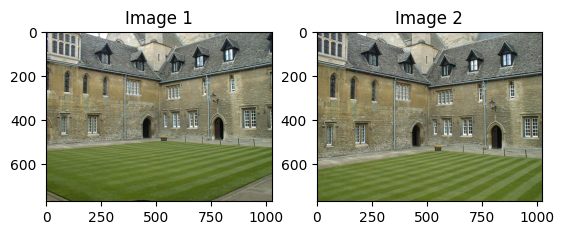

In [12]:
# Display images
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.title('Image 2')
plt.imshow(im2)
plt.show()


In [ ]:
!unzip metron.zip

Archive:  metron.zip
   creating: metron/2D/
   creating: metron/2D/.ipynb_checkpoints/
  inflating: metron/2D/.ipynb_checkpoints/003-checkpoint.lines  
  inflating: metron/2D/.ipynb_checkpoints/003-checkpoint.P  
  inflating: metron/2D/.ipynb_checkpoints/nview-lines-checkpoint  
  inflating: metron/2D/.ipynb_checkpoints/README-2D-checkpoint  
  inflating: metron/2D/001.corners   
  inflating: metron/2D/001.lines     
  inflating: metron/2D/001.P         
  inflating: metron/2D/002.corners   
  inflating: metron/2D/002.lines     
  inflating: metron/2D/002.P         
  inflating: metron/2D/003.corners   
  inflating: metron/2D/003.lines     
  inflating: metron/2D/003.P         
  inflating: metron/2D/nview-corners  
  inflating: metron/2D/nview-lines   
  inflating: metron/2D/README-2D     
   creating: metron/3D/
   creating: metron/3D/.ipynb_checkpoints/
  inflating: metron/3D/.ipynb_checkpoints/l3d-checkpoint  
  inflating: metron/3D/.ipynb_checkpoints/p3d-checkpoint  
  inflating:

In [13]:
# Load 2D points for each view
points2D = [np.loadtxt(f'/content/metron/2D/00{i+1}.corners').T for i in range(2)]

In [14]:
def draw_points(img, points):
    """ Draw points on an image. """
    img_with_points = img.copy()
    for pt in points.T:  # Transpose to iterate over columns
        pt = np.round(pt).astype(int)  # Round and convert point to integers
        pt = tuple(pt)  # Convert point to tuple
        if len(pt) == 2:  # Ensure point has exactly 2 coordinates
            img_with_points = cv2.circle(img_with_points, pt, 5, (0, 255, 0), -1)
    return img_with_points


In [15]:
im1_with_points = draw_points(im1, points2D[0])
im2_with_points = draw_points(im2, points2D[1])

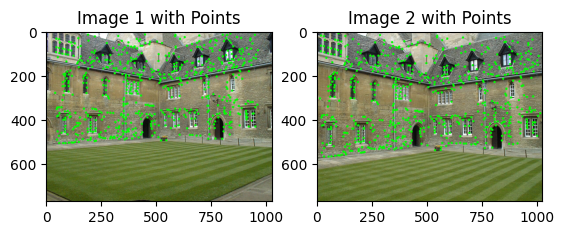

In [16]:
plt.subplot(1, 2, 1)
plt.title('Image 1 with Points')
plt.imshow(im1_with_points)
plt.subplot(1, 2, 2)
plt.title('Image 2 with Points')
plt.imshow(im2_with_points)
plt.show()

In [17]:
# Load correspondences
corr = np.genfromtxt('metron/2D/nview-corners', dtype=int, missing_values='*', filling_values=-1)
pts1 = []
pts2 = []
for i in range(len(corr)):
    if corr[i, 0] != -1 and corr[i, 1] != -1:
        pts1.append(points2D[0][:, corr[i, 0]])
        pts2.append(points2D[1][:, corr[i, 1]])
pts1 = np.array(pts1)
pts2 = np.array(pts2)



In [18]:
# Compute fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


In [20]:
def draw_epilines(img1, img2, pts1, pts2, F):
    """ Draw epipolar lines on the images. """
    def draw_lines(img, lines, pts):
        """ Draw lines on an image. """
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        for line, pt in zip(lines, pts):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -line[2] / line[1]])
            x1, y1 = map(int, [img.shape[1], -(line[2] + line[0] * img.shape[1]) / line[1]])
            img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
            img = cv2.circle(img, tuple(pt.astype(int)), 5, color, -1)
        return img

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img1_lines = draw_lines(img1, lines1, pts1)

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img2_lines = draw_lines(img2, lines2, pts2)

    return img1_lines, img2_lines


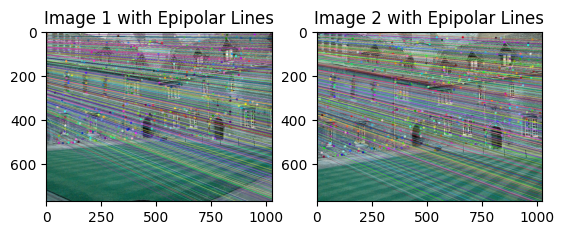

In [21]:
img1_with_lines, img2_with_lines = draw_epilines(im1, im2, pts1, pts2, F)

plt.subplot(1, 2, 1)
plt.title('Image 1 with Epipolar Lines')
plt.imshow(img1_with_lines)
plt.subplot(1, 2, 2)
plt.title('Image 2 with Epipolar Lines')
plt.imshow(img2_with_lines)
plt.show()